
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
Artificial Intelligence <br>
<font color=2565AE size=5>
Computer Engineering Department <br>
Spring 2024<br>
<font color=3C99D size=5>
Practical Assignment 5 - RL <br>
<font color=696880 size=4>
Amirmahdi Meighani


____

# Personal Data

In [ ]:
# Set your student number and name
student_number = 99105429
Name = Amirhossein
Last_Name = Khoshbakht

# Rules

<font color=red>
Please run all the cells.
</font>

# Q1: Mountain Car (100 Points)

In this notebook we have a game called mountain car. the car is in a valley and at evey moment we can model its state using two floats as speed and location along x axis. You can control the car using three actions.

0: Accelerate to the left

1: Don’t accelerate

2: Accelerate to the right

the goal is to reach the peak of mountain in the minimum number of frames. because you get -1 reward for evey timestamp.

you should model the countious enviroment with a approximate descrete one and train your agent using Q learning and SARSA algorithms.


install required libraries

In [1]:
!pip install numpy
!pip install matplotlib
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.7 MB/s eta 0:00:00


## imports

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [3]:
def visualize(env):
    '''
    use this function to see the state of the game in the current moment
    '''
    env_screen = env.render()
    plt.imshow(env_screen)
    plt.axis('off');
    title = 'speed is ' + str(env.unwrapped.state[1])

    plt.title(title)
    plt.show()

## Q Learning

in this question we have a countious enviroment but you can approximate it as a discrete enviormnet then learn and act according to that.

you can see the information of game below.

In [4]:
env = gym.make("MountainCar-v0",render_mode='rgb_array',max_episode_steps=200)
spec = gym.spec('MountainCar-v0')

Action Space: Discrete(3)
Observation Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Max Episode Steps: 200
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: -110.0



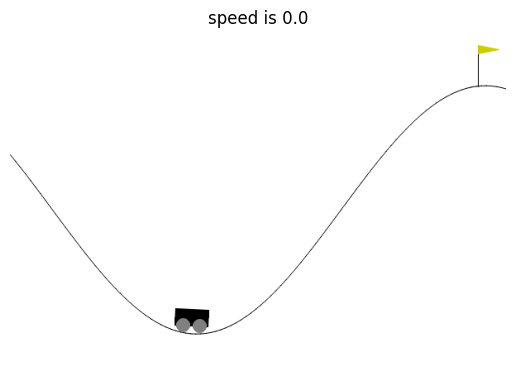

In [5]:
print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")
print(f"Max Episode Steps: {spec.max_episode_steps}")
print(f"Nondeterministic: {spec.nondeterministic}")
print(f"Reward Range: {env.reward_range}")
print(f"Reward Threshold: {spec.reward_threshold}\n")
env.reset()
visualize(env)

Observation Space:
The observation is a ndarray with shape (2,) where the elements correspond to the following:

| Num |              Observation             |  Min  |  Max |
|:---:|:------------------------------------:|:-----:|:----:|
|  0  | position of the car along the x-axis |  -1.2 |  0.6 |
|  1  | velocity of the car                  | -0.07 | 0.07 |

Action Space:
There are 3 discrete deterministic actions:

0: Accelerate to the left

1: Don’t accelerate

2: Accelerate to the right

You can play in this env yourself!!!

Try some actions and visulize the env after every 5 action. use env.step(action) function to do actions. print output of some step function. It returns five values :

new_state, reward, is_terminated ,is_truncated ,extra_info

new state after the action, reward for that action in that step, is the game terminated by reaching the goal, is the game finished by reaching 200 episode limit that is the default in this game, and some possible extra info that we don't use.


In [6]:
env.reset() # You can use this function to reset your environment.
######################## YOUR CODE HERE ########################


######################## END YOUR CODE #########################
env.reset()

(array([-0.5641855,  0.       ], dtype=float32), {})

the state consists of two floats.  first one is position in x axis and second one is speed. in the next cell we will write our agent. First we need to convert continuous state to descrete so complete the relevant functions. after that we need to train our agent using Q_learning formula:


$$ Q(s,a) \leftarrow Q(s,a) + \alpha \left( r + \gamma \max_{a'} Q(s',a') - Q(s,a) \right) $$

After training we use create policy to save your best actions. Then evaluate your policy.

In [7]:
class MountainCarQL:

    def __init__(self, env, discrete_size=20):
        self.discrete_size = discrete_size  # Number of states we use instead of each continuous argument of state
        self.env = env
        self.q_values = self.create_q_values_list()
        self.policy = {}

    def create_q_values_list(self):
        # Initialize q_table with zeros
        return np.zeros((self.discrete_size, self.discrete_size, self.env.action_space.n))

    def get_discrete_state(self, state):
        discrete_state = (state - self.env.observation_space.low) / (self.env.observation_space.high - self.env.observation_space.low)
        discrete_state = np.round(discrete_state * (self.discrete_size - 1)).astype(int)
        return tuple(discrete_state)

    def learn(self, num_episodes, alpha, gamma, epsilon):
        for episode in range(num_episodes):
            state = self.env.reset()[0]
            discrete_state = self.get_discrete_state(state)
            done = False

            while not done:
                if np.random.random() > epsilon:
                    action = np.argmax(self.q_values[discrete_state])
                else:
                    action = np.random.randint(0, self.env.action_space.n)

                new_state, reward, done, _, _ = self.env.step(action)
                new_discrete_state = self.get_discrete_state(new_state)

                if not done:
                    max_future_q = np.max(self.q_values[new_discrete_state])
                    current_q = self.q_values[discrete_state + (action,)]
                    new_q = (1 - alpha) * current_q + alpha * (reward + gamma * max_future_q)
                    self.q_values[discrete_state + (action,)] = new_q
                elif new_state[0] >= self.env.goal_position:
                    self.q_values[discrete_state + (action,)] = 0

                discrete_state = new_discrete_state

    def create_policy(self):
        for i in range(self.discrete_size):
            for j in range(self.discrete_size):
                self.policy[(i, j)] = np.argmax(self.q_values[i, j])

    def act(self, state):
        discrete_state = self.get_discrete_state(state)
        return self.policy[discrete_state]

    def evaluate(self, num_episodes):
        total_reward = 0
        success_count = 0

        for _ in range(num_episodes):
            state = self.env.reset()[0]
            done = False
            episode_reward = 0

            while not done:
                action = self.act(state)
                new_state, reward, done, _, _ = self.env.step(action)
                episode_reward += reward
                state = new_state

                if new_state[0] >= self.env.goal_position:
                    success_count += 1

            total_reward += episode_reward

        avg_reward = total_reward / num_episodes
        success_rate = success_count / num_episodes * 100
        return avg_reward, success_rate

# Train and evaluate the agent
EPISODES = 5000
LEARNING_RATE = 0.1
DISCOUNT = 0.99
EPSILON = 0.1
DISCRETE_SIZE = 20

mountain_car_ql = MountainCarQL(env, discrete_size=DISCRETE_SIZE)
mountain_car_ql.learn(EPISODES, LEARNING_RATE, DISCOUNT, EPSILON)
mountain_car_ql.create_policy()

avg_reward, success_rate = mountain_car_ql.evaluate(200)
print(f"Average Reward: {avg_reward}")
print(f"Success Rate: {success_rate}%")


/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.goal_position to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.goal_position` for environment variables or `env.get_wrapper_attr('goal_position')` that will search the reminding wrappers.
  logger.warn(


Average Reward: -142.735
Success Rate: 100.0%


train your agent with good parameters

In [ ]:
EPISODES = None
LEARNING_RATE = None
DISCOUNT = None
EPSILON = None
DISCRETE_SIZE = None


mountain_car_ql = MountainCarQL(env,discrete_size=DISCRETE_SIZE)
mountain_car_ql.learn(EPISODES, LEARNING_RATE, DISCOUNT, EPSILON)


*evaluate* your agent with at least 200 episodes. your average score must be more than -170.

In [ ]:
# todo


(-141.83666666666667, 97.33333333333333)


show the path your car took for only one episode. Use visualize function every 10 frame.



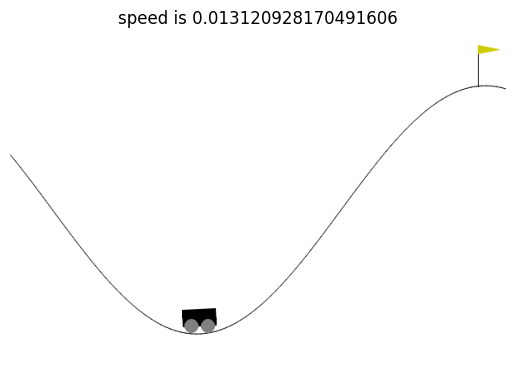

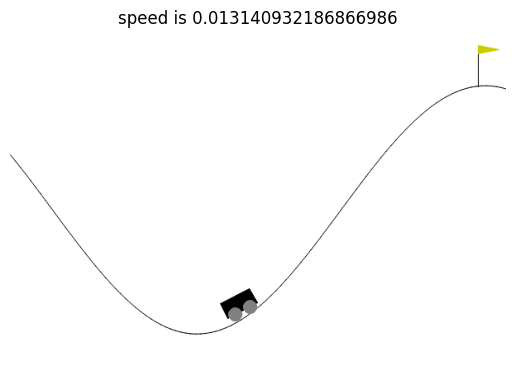

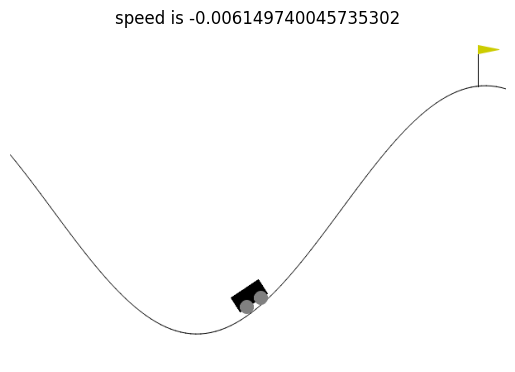

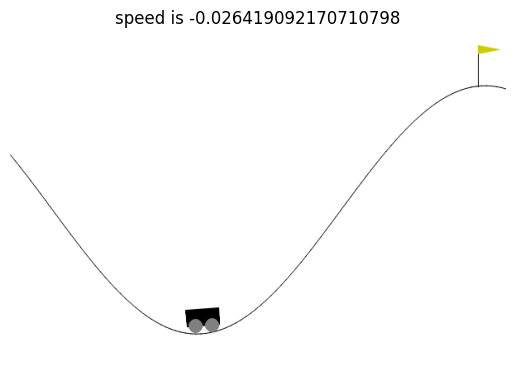

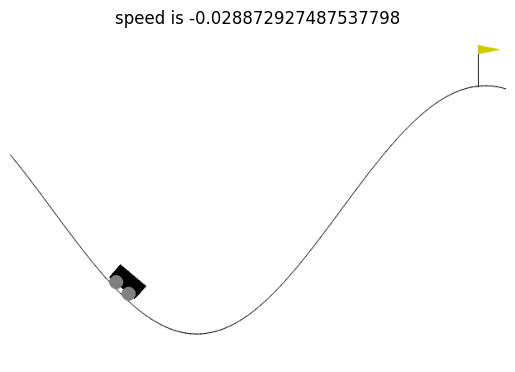

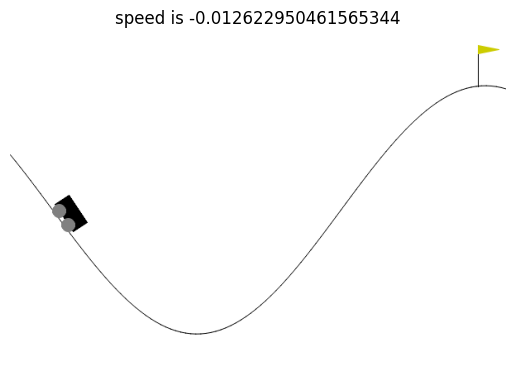

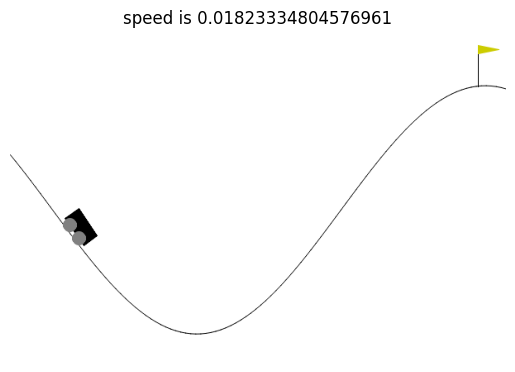

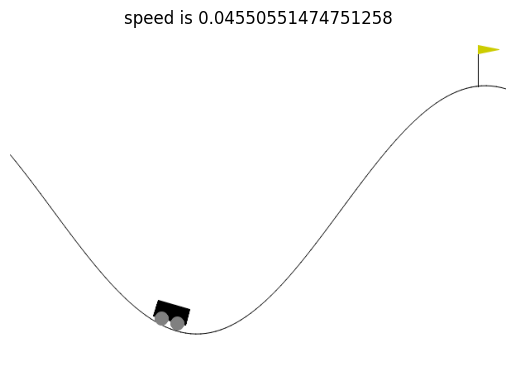

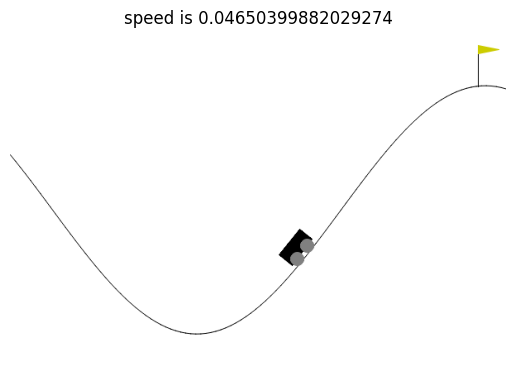

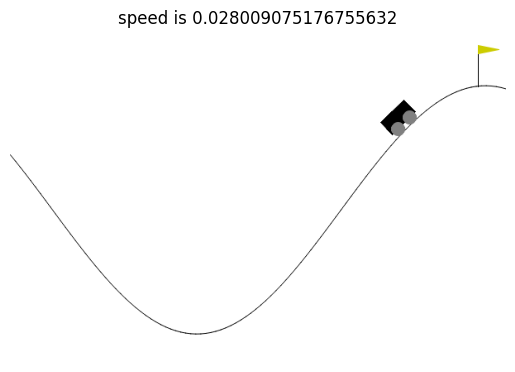

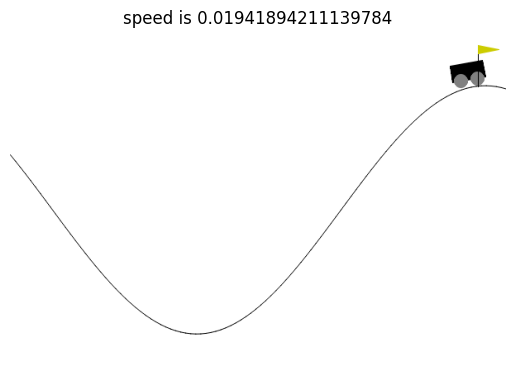

(array([-0.43799376,  0.        ], dtype=float32), {})

In [8]:
# todo
env.reset()
state = env.reset()[0]
done = False
frame_count = 0

while not done:
    action = mountain_car_ql.act(state)
    state, reward, done, _, _ = env.step(action)
    frame_count += 1
    if frame_count % 10 == 0:
        visualize(env)

env.reset()


## SARSA
now we want to use sarsa algorithm here instead of Q learning. The update rule is:

$$Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \left( R_{t+1} + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t) \right)$$

Average Reward: -160.465
Success Rate: 100.0%


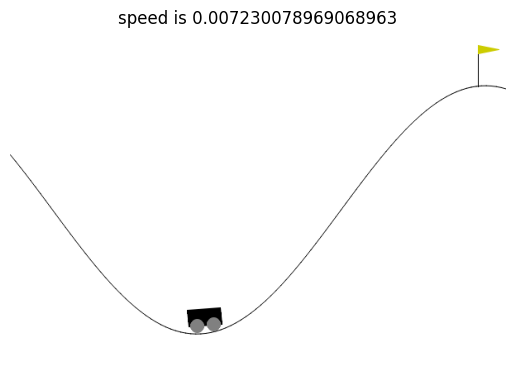

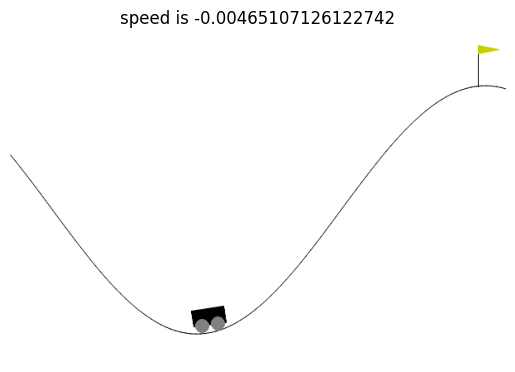

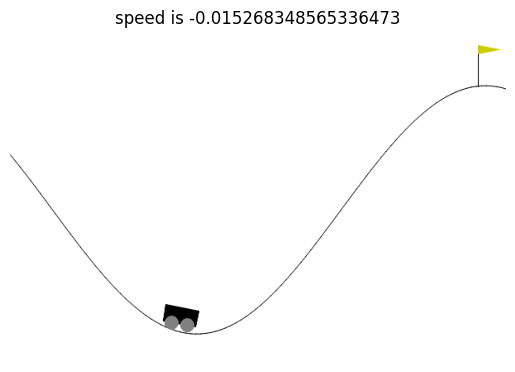

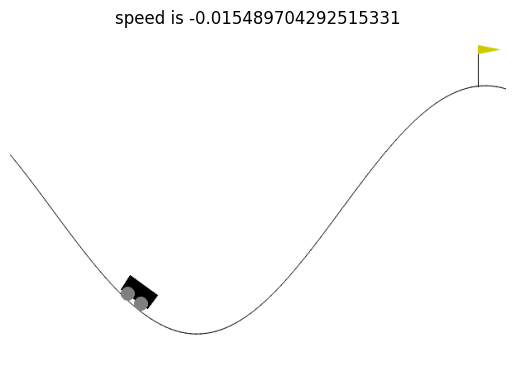

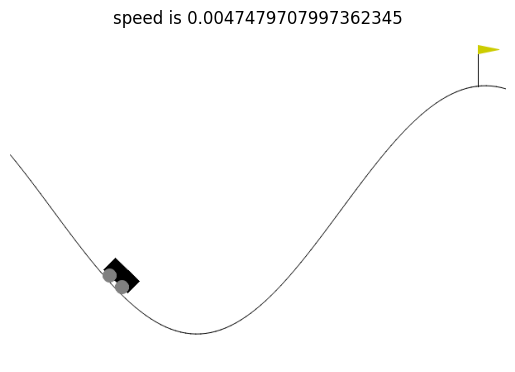

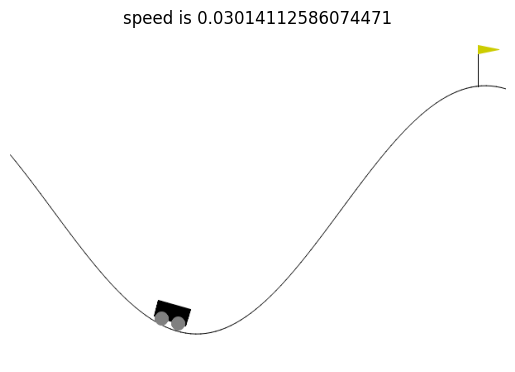

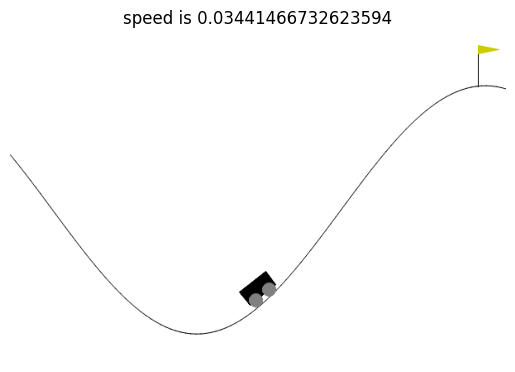

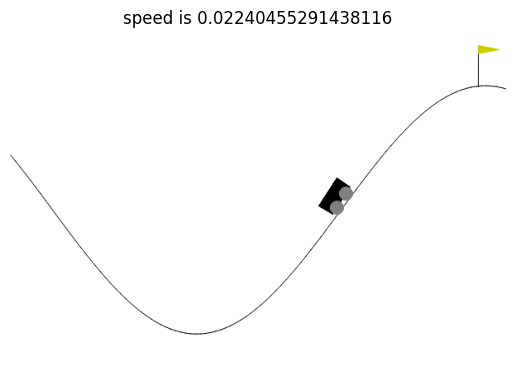

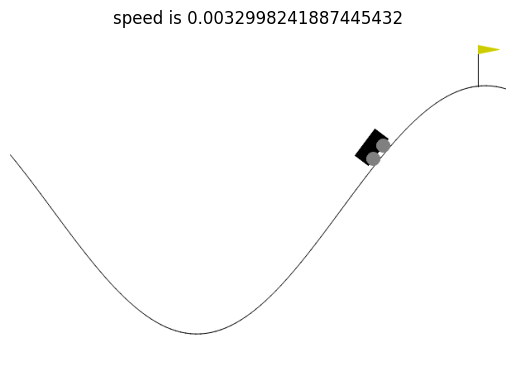

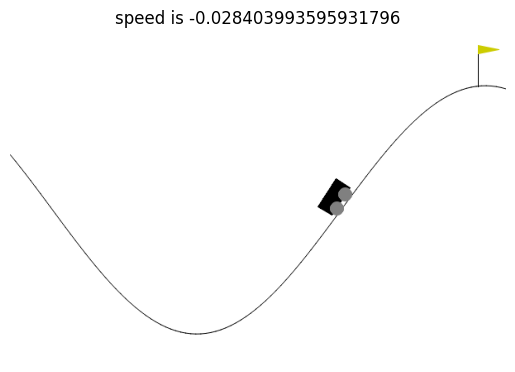

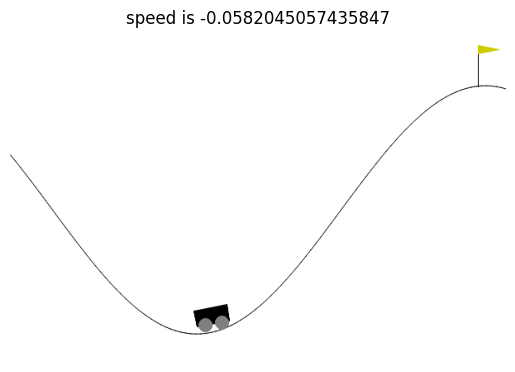

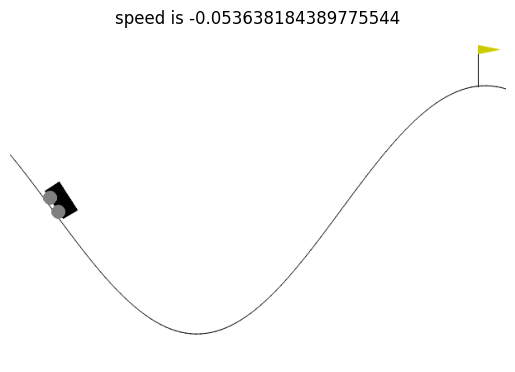

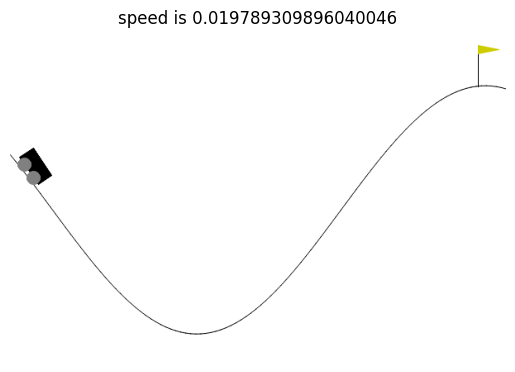

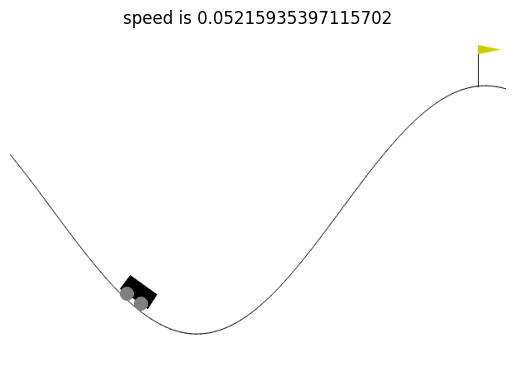

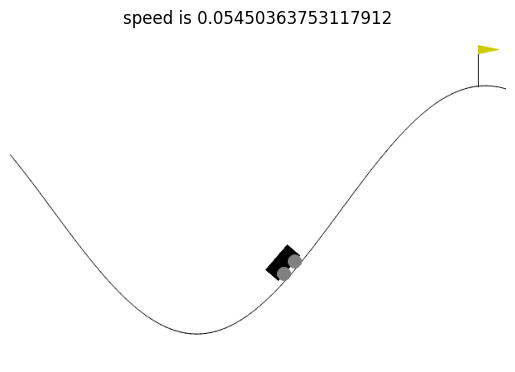

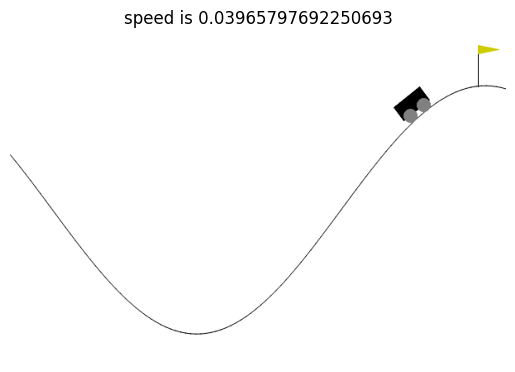

(array([-0.41293722,  0.        ], dtype=float32), {})

In [9]:
class MountainCarSarsa(MountainCarQL):

    def learn(self, num_episodes, alpha, gamma, epsilon):
        for episode in range(num_episodes):
            state = self.env.reset()[0]
            discrete_state = self.get_discrete_state(state)
            done = False

            if np.random.random() > epsilon:
                action = np.argmax(self.q_values[discrete_state])
            else:
                action = np.random.randint(0, self.env.action_space.n)

            while not done:
                new_state, reward, done, _, _ = self.env.step(action)
                new_discrete_state = self.get_discrete_state(new_state)

                if np.random.random() > epsilon:
                    new_action = np.argmax(self.q_values[new_discrete_state])
                else:
                    new_action = np.random.randint(0, self.env.action_space.n)

                if not done:
                    current_q = self.q_values[discrete_state + (action,)]
                    future_q = self.q_values[new_discrete_state + (new_action,)]
                    new_q = (1 - alpha) * current_q + alpha * (reward + gamma * future_q)
                    self.q_values[discrete_state + (action,)] = new_q
                elif new_state[0] >= self.env.goal_position:
                    self.q_values[discrete_state + (action,)] = 0

                discrete_state = new_discrete_state
                action = new_action

# Train and evaluate the SARSA agent
mountain_car_sarsa = MountainCarSarsa(env, discrete_size=DISCRETE_SIZE)
mountain_car_sarsa.learn(EPISODES, LEARNING_RATE, DISCOUNT, EPSILON)
mountain_car_sarsa.create_policy()

avg_reward, success_rate = mountain_car_sarsa.evaluate(200)
print(f"Average Reward: {avg_reward}")
print(f"Success Rate: {success_rate}%")

# Visualize the SARSA agent's path
env.reset()
state = env.reset()[0]
done = False
frame_count = 0

while not done:
    action = mountain_car_sarsa.act(state)
    state, reward, done, _, _ = env.step(action)
    frame_count += 1
    if frame_count % 10 == 0:
        visualize(env)

env.reset()


train your agent with good parameters

In [ ]:
EPISODES = None
LEARNING_RATE = None
DISCOUNT = None
EPSILON = None
DISCRETE_SIZE = None

mountain_car_sarsa = MountainCarSarsa(env,discrete_size=DISCRETE_SIZE)
mountain_car_sarsa.learn(EPISODES, LEARNING_RATE, DISCOUNT, EPSILON)


evaluate your agent with at list 200 episodes. your average score must be more than -175.

In [ ]:
# todo



(-174.89333333333335, 69.66666666666667)


show the path your car took for only one episode. Use visualize function every 10 frame.

In [ ]:
# todo

Is there any difference between the two algorithms? Compare results and explain why.

Answer:...

